I have used the following methods.

* I have implemented DeepLabv3+ stemmed from this Keras example[1,2],
* I converted the original masks to <b><span style="color:#e74c3c;"> binary masks</span></b> in the image preprocessing stage (I suppose that the original source of the dataset contains  tiff images or another type of 16 bit depth images.),
* <b>Dice coefficient</b> and <b>Jaccard index</b> implementation[3],
* I used <b> <b><span style="color:#e74c3c;"> DeepLabv3+ implementation</span></b> with ResNet50 backbone,
* Used tf.data for input pipeline,
* <b>A Custom layer</b> for convolution operation,
* <b>A Custom layer</b> for Dilated Spatial Pyramid Pooling operation,


## Evaluation Results

| after 25 epochs  | Train (418 imgs) | Valid (63 imgs) | Test (47 imgs) |
|------------------|------------------|------------------|-----------------|
| Loss             | 0.0211           | 0.2282           | 0.1159          |
| Dice Loss        | 0.0200           | 0.0725           | 0.0613          |
| Dice Coefficient | 0.9800           | 0.9275           | <b>0.9387 </b>  |
| Jaccard Index    | 0.9608           | 0.8656           | <b>0.8869    </b>  |

 
## Test Set Predictions
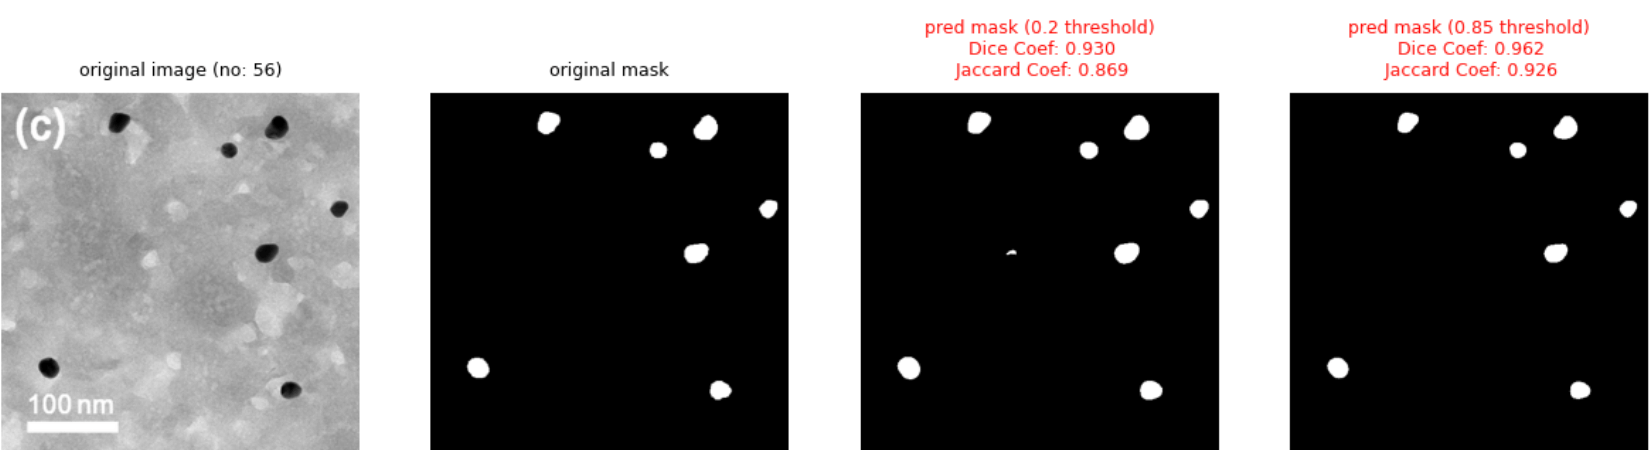
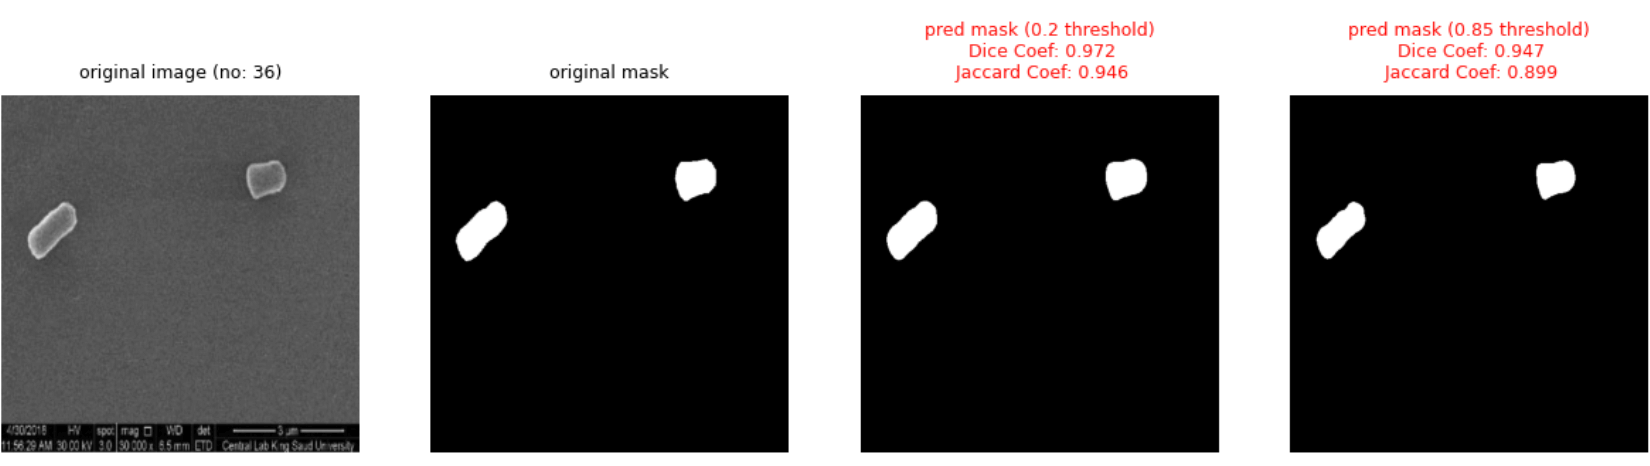
    
    
## My Another Segmentation Projects

* [(76 GB) 160 Polish Bird Sounds Classification](https://www.kaggle.com/code/banddaniel/76-gb-160-polish-bird-sounds-classification)
* [Polyp Segmentation w/Custom DeepLabv3+(Dice: 0.77)](https://www.kaggle.com/code/banddaniel/polyp-segmentation-w-custom-deeplabv3-dice-0-77)
* [Lung Segmentation UNet w/SeparableConv (Dice:0.93)](https://www.kaggle.com/code/banddaniel/lung-segmentation-unet-w-separableconv-dice-0-93)
* [Brain tumor/anomaly segmentation with Unet using TPU](https://github.com/john-fante/brain-tumor-segmentation-tpu)
* [Brain tissue segmentation with Unet using TPU (Dice: 0.88)](https://github.com/john-fante/brain-tissue-segmentation-tpu)


## References
1. https://keras.io/examples/vision/deeplabv3_plus/#building-the-deeplabv3-model
2. Chen, L.-C., Zhu, Y., Papandreou, G., Schroff, F., & Adam, H. (2018). Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation (Version 3). arXiv. https://doi.org/10.48550/ARXIV.1802.02611
3. https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient

In [1]:
# Importing dependencies

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Dropout,Concatenate, BatchNormalization, SeparableConv2D
from tensorflow.keras.layers import Activation, MaxPooling2D, AveragePooling2D, Dense, concatenate, GlobalAveragePooling2D


SEED = 3
IMG_SIZE = 512,512
BATCH_SIZE = 8
AUTO = tf.data.AUTOTUNE

# <span style="color:#e74c3c;"> Image </span> Preprocessing

In [2]:
os.mkdir(os.path.join('/kaggle/working/', 'converted_masks'))

In [3]:
# A function that is used for converting binary masks
def convert_binary_masks(main_path, target_path):
    for i in sorted(os.listdir(main_path)):
        img = cv2.imread(os.path.join(main_path, i ), cv2.IMREAD_UNCHANGED)
        f, bw_img = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY)
        bw_img = np.asarray(bw_img, dtype = np.uint8)

        cv2.imwrite(os.path.join(target_path,i), bw_img)

In [4]:
# Applying preprocessing functions to masks

convert_binary_masks('/kaggle/input/electron-microscopy-particle-segmentation/segmaps', '/kaggle/working/converted_masks')        

# <span style="color:#e74c3c;"> Creating </span> Datasets


In [5]:
# Creating main dataframe contains image paths and their mask paths.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))

    for i in images:
        full_path.append(os.path.join(path, i))
        
    return full_path


images = create_images_list('/kaggle/input/electron-microscopy-particle-segmentation/images')
masks = create_images_list('/kaggle/working/converted_masks')

full_data = pd.DataFrame({'image': images, 'mask': masks})
full_data = shuffle(full_data).reset_index().drop(columns=['index'])

# <span style="color:#e74c3c;"> Creating </span> Train, Val, Test Datasets


In [6]:
X_data, X_test, y_data, y_test = train_test_split(full_data['image'], full_data['mask'], test_size = 0.1, random_state = SEED)
X_train, X_validation, y_train, y_validation = train_test_split(X_data, y_data, test_size = 0.15, random_state = SEED + 1)

print("X_train shape -> ", X_train.shape)
print("X_val shape -> ", X_validation.shape)
print("X_test shape -> ", X_test.shape)

X_train shape ->  (355,)
X_val shape ->  (63,)
X_test shape ->  (47,)


# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [7]:
# Reading and resizing images and masks

def img_preprocessing(image, mask):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    mask = tf.io.read_file(mask)
    mask = tf.io.decode_jpeg(mask, channels = 1)
    mask = tf.image.resize(mask, size = (IMG_SIZE))
    #mask = tf.cast(mask, tf.float32) / 255.0
    
    return img, mask

In [8]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .shuffle(X_data.shape[0])
                 .prefetch(AUTO))


validation_loader = tf.data.Dataset.from_tensor_slices((X_validation, y_validation))
validation_dataset = (validation_loader
                      .map(img_preprocessing, num_parallel_calls = AUTO)
                      .batch(BATCH_SIZE)
                      .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls = AUTO)
                .batch(BATCH_SIZE)
                .prefetch(AUTO))

# <span style="color:#e74c3c;"> Creating </span> Custom Layers

In [9]:
# Convolutional block class

class ConvBlock(Layer):
    def __init__(self, filters, kernel_size, dilation_rate, batch = False, padding = 'same', activation = 'relu', use_bias = False, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.batch = batch
        self.padding = padding
        self.activation = activation
        self.use_bias = use_bias
        
        self.conv = Conv2D(filters, kernel_size = kernel_size, dilation_rate = dilation_rate, padding = padding, use_bias = use_bias, kernel_initializer = 'he_normal')
        self.norm = BatchNormalization()
        self.act = Activation(activation)
    
    def call(self, inputs):
        X = self.conv(inputs)
        if self.batch:
            X = self.norm(X)
            X = self.act(X)
            return X
        else:
            X = self.act(X)
            return X
            

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size" : self.kernel_size,
            "dilation_rate" : self.dilation_rate,
            "activation" : self.act,
            "batch" : self.batch }


In [10]:
# DilatedSpatialPyramidPooling class for DeepLabv3+ model

class DilatedSpatialPyramidPooling(Layer):
    def __init__(self, input_layer, kernel_1, kernel_2, kernel_3, kernel_4, dil1, dil2, dil3, dil4, **kwargs):
        super(DilatedSpatialPyramidPooling, self).__init__(**kwargs)
        self.input_layer = input_layer
        self.kernel_1 = kernel_1
        self.kernel_2 = kernel_2
        self.kernel_3 = kernel_3
        self.kernel_4 = kernel_4
        self.dil1 = dil1
        self.dil2 = dil2
        self.dil3 = dil3
        self.dil4 = dil4
 
        self.pool = AveragePooling2D(pool_size = (input_layer.shape[-3], input_layer.shape[-2]))
        self.convblock = ConvBlock(filters = 256, kernel_size=1, dilation_rate=1, batch = True, use_bias=True)
        self.outpool = UpSampling2D(size=(32,32), interpolation="bilinear")
        self.convout1 = ConvBlock(filters = 256, kernel_size = kernel_1, dilation_rate = dil1, batch = True)
        self.convout2 = ConvBlock(filters = 256, kernel_size = kernel_2, dilation_rate = dil2, batch = True)
        self.convout3 = ConvBlock(filters = 256, kernel_size = kernel_3, dilation_rate = dil3, batch = True)
        self.convout4 = ConvBlock(filters = 256, kernel_size = kernel_4, dilation_rate = dil4, batch = True)
        self.outconv = ConvBlock(filters = 256, kernel_size = 1, dilation_rate=1, batch = True)

    
    def call(self, inputs):
        X = self.pool(inputs)
        X = self.convblock(X)
        X_p = self.outpool(X)
        X_1 = self.convout1(inputs)
        X_2 = self.convout2(inputs)
        X_3 = self.convout3(inputs)
        X_4 = self.convout4(inputs)
        
        C = concatenate([X_p, X_1, X_2, X_3, X_4], axis = -1)
        X = self.outconv(C)
        return X

    
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "input_layer": self.input_layer,
            "kernel_1" : self.kernel_1,
            "kernel_2" : self.kernel_2,
            "kernel_3" : self.kernel_3,
            "kernel_4" : self.kernel_4,
            "dil1" : self.dil1,
            "dil2" : self.dil2,
            "dil3" : self.dil3,
            "dil4" : self.dil4}

In [11]:
# Creating Dice and Jaccard metrics

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection+1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def jaccard(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    jaccard = intersection  / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1e-6 )
    return jaccard

# <span style="color:#e74c3c;"> DeepLabv3+</span> Model


In [12]:
inp = Input(shape = (*IMG_SIZE ,3))
pretrained = ResNet50(weights="imagenet", include_top=False, input_tensor=inp)
X = pretrained.get_layer("conv4_block6_2_relu").output
X = DilatedSpatialPyramidPooling(X, kernel_1 = 1, kernel_2 = 3, kernel_3 = 3, kernel_4 = 3,
                                 dil1 = 1, dil2 = 6, dil3 = 12, dil4 = 18)(X)

X_1 = UpSampling2D(size = (IMG_SIZE[0] // 4 // X.shape[1], IMG_SIZE[0] // 4 // X.shape[2]), interpolation="bilinear")(X)

X_2 = pretrained.get_layer("conv2_block3_2_relu").output
X_2 = ConvBlock(filters=48, kernel_size=1, dilation_rate =1)(X_2)

X = Concatenate(axis=-1)([X_1, X_2])
X = ConvBlock(filters = 256, kernel_size = 3, dilation_rate = 1)(X)
X = ConvBlock(filters = 256, kernel_size = 3, dilation_rate = 1)(X)
X = UpSampling2D(size = (IMG_SIZE[0] // X.shape[1], IMG_SIZE[0] // X.shape[2]), interpolation="bilinear")(X)

out = Conv2D(1, 1 ,activation ='sigmoid', padding = 'same')(X)

model = Model(inputs = inp, outputs = out)
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy' , metrics = [dice_coef_loss, dice_coef, jaccard]) 


94765736/94765736 [==============================] - 0s 0us/step


# <span style="color:#e74c3c;"> Training </span> 


In [13]:
hist = model.fit(train_dataset, batch_size = BATCH_SIZE, epochs = 25, validation_data = validation_dataset)

Epoch 1/25
45/45 [==============================] - 77s 580ms/step - loss: 0.4900 - dice_coef_loss: 0.3811 - dice_coef: 0.6189 - jaccard: 0.4658 - val_loss: 5.6464 - val_dice_coef_loss: 1.0000 - val_dice_coef: 6.2530e-06 - val_jaccard: 2.3572e-06
Epoch 2/25
45/45 [==============================] - 21s 394ms/step - loss: 0.2575 - dice_coef_loss: 0.2333 - dice_coef: 0.7667 - jaccard: 0.6273 - val_loss: 2.6263 - val_dice_coef_loss: 0.9979 - val_dice_coef: 0.0021 - val_jaccard: 0.0010
Epoch 3/25
45/45 [==============================] - 22s 401ms/step - loss: 0.2045 - dice_coef_loss: 0.1875 - dice_coef: 0.8125 - jaccard: 0.6881 - val_loss: 0.7807 - val_dice_coef_loss: 0.7476 - val_dice_coef: 0.2524 - val_jaccard: 0.1446
Epoch 4/25
45/45 [==============================] - 22s 401ms/step - loss: 0.1574 - dice_coef_loss: 0.1436 - dice_coef: 0.8564 - jaccard: 0.7519 - val_loss: 2.0529 - val_dice_coef_loss: 0.9737 - val_dice_coef: 0.0263 - val_jaccard: 0.0133
Epoch 5/25
45/45 [==================

# <span style="color:#e74c3c;"> Training </span> Results, Evaluation

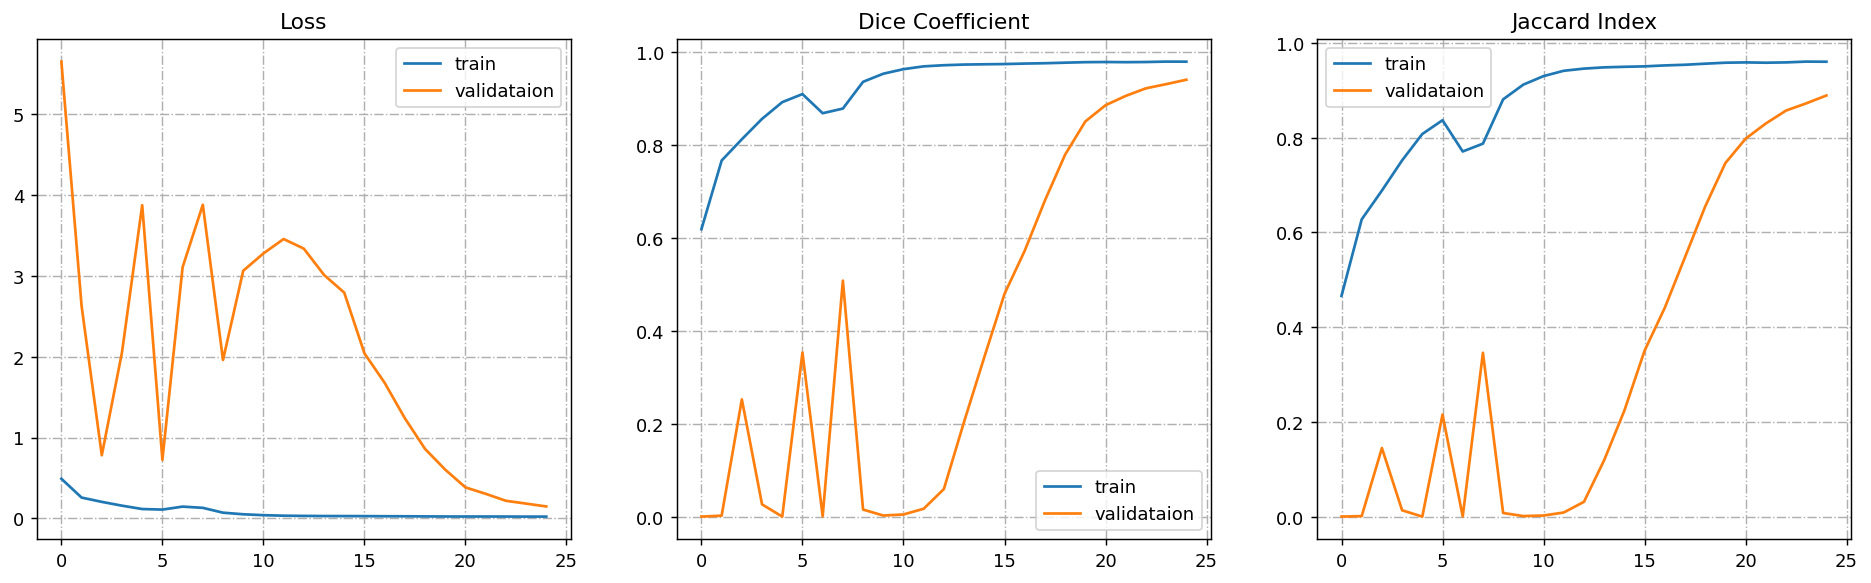

In [14]:
fig, axs = plt.subplots(1,3, figsize = (18,5), dpi = 130)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Loss")
axs[0].plot(hist.history['loss'])
axs[0].plot(hist.history['val_loss'])
axs[0].legend(["train", "validataion"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Dice Coefficient")
axs[1].plot(hist.history['dice_coef'])
axs[1].plot(hist.history['val_dice_coef'])
axs[1].legend(["train",  "validataion"])

axs[2].grid(linestyle="dashdot")
axs[2].set_title("Jaccard Index")
axs[2].plot(hist.history['jaccard'])
axs[2].plot(hist.history['val_jaccard'])
axs[2].legend(["train",  "validataion"])

# <span style="color:#e74c3c;"> Test and Validation </span> Evaluation

In [15]:
val_eval = model.evaluate(validation_dataset)
test_eval = model.evaluate(test_dataset)

6/6 [==============================] - 1s 121ms/step - loss: 0.3272 - dice_coef_loss: 0.1043 - dice_coef: 0.8957 - jaccard: 0.8149


# <span style="color:#e74c3c;"> Test </span> Predictions

In [16]:
test_take1 =  validation_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model.predict(test_take1)

y_test_take = []
for x in range(len(test_take1_)):
    y_test_take.extend(test_take1_[x][1].numpy())
    
pred_ = np.squeeze(pred)

threshold_1  = 0.2 #threshold for prediction
bitmap_pred_1 = (pred_ > threshold_1).astype(np.uint8)

threshold_2  = 0.85 #threshold for prediction
bitmap_pred_2 = (pred_ > threshold_2).astype(np.uint8)

8/8 [==============================] - 2s 126ms/step


In [17]:
# A function that calculating dice and jaccard metrics for prediction
def calc_dice_jaccard_for_prediction(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = tf.cast(y_true_f, tf.uint32)
    y_pred_f = tf.cast(y_pred_f, tf.uint32)

    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2 * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) +  1)
    jaccard = intersection  / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)
    
    return dice.numpy(),jaccard.numpy()


# A function that creating 3 random images in the test set and prediction it
def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(y_test_take))[:3]

    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

   
    fig, axs = plt.subplots(3,4, figsize = (10, 10 ) ,dpi = 150)
    
    for i in range(3):
        image = test_take1_[batch_idx[i]][0][image_idx[i]]
        mask = test_take1_[batch_idx[i]][1][image_idx[i]]
        pred_mask_1 = bitmap_pred_1[idx[i]]
        pred_mask_2 = bitmap_pred_2[idx[i]]
        
        dice1 = calc_dice_jaccard_for_prediction(mask, pred_mask_1)[0]
        jac1 = calc_dice_jaccard_for_prediction(mask, pred_mask_1)[1]
        
        dice2= calc_dice_jaccard_for_prediction(mask, pred_mask_2)[0]
        jac2= calc_dice_jaccard_for_prediction(mask, pred_mask_2)[1]
        

        axs[i][0].imshow(image , cmap = 'gray')
        axs[i][0].axis('off')
        axs[i][0].set_title('original image (no: ' + str(idxs[i]) + ")", fontsize = 6)

        axs[i][1].imshow(mask, cmap = 'gray')
        axs[i][1].axis('off')
        axs[i][1].set_title('original mask', fontsize = 6)

        axs[i][2].imshow(pred_mask_1 , cmap = 'gray')
        axs[i][2].axis('off')
        axs[i][2].set_title('pred mask (0.2 threshold)'
                            + '\n Dice Coef: {0:0.3f}'.format(dice1) 
                            + '\n Jaccard Coef: {0:0.3f}'.format(jac1), color = 'red', fontsize = 6)
    
        axs[i][3].imshow(pred_mask_2 , cmap = 'gray')
        axs[i][3].axis('off')
        axs[i][3].set_title('pred mask (0.85 threshold)' + '\n Dice Coef: {0:0.3f}'.format(dice2) + '\n Jaccard Coef: {0:0.3f}'.format(jac2), color = 'red', fontsize = 6)

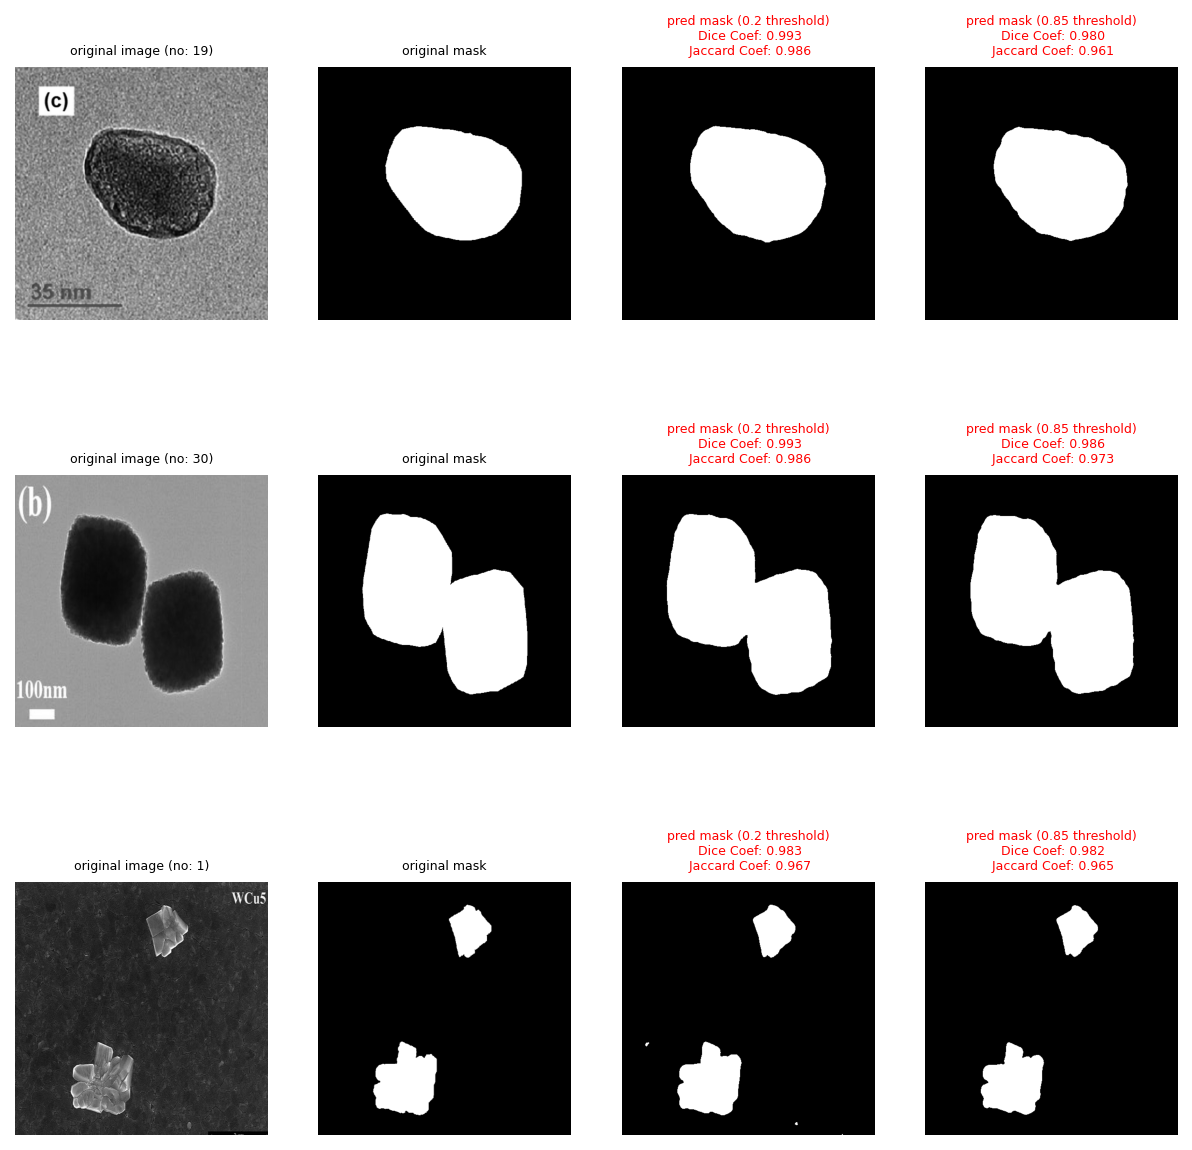

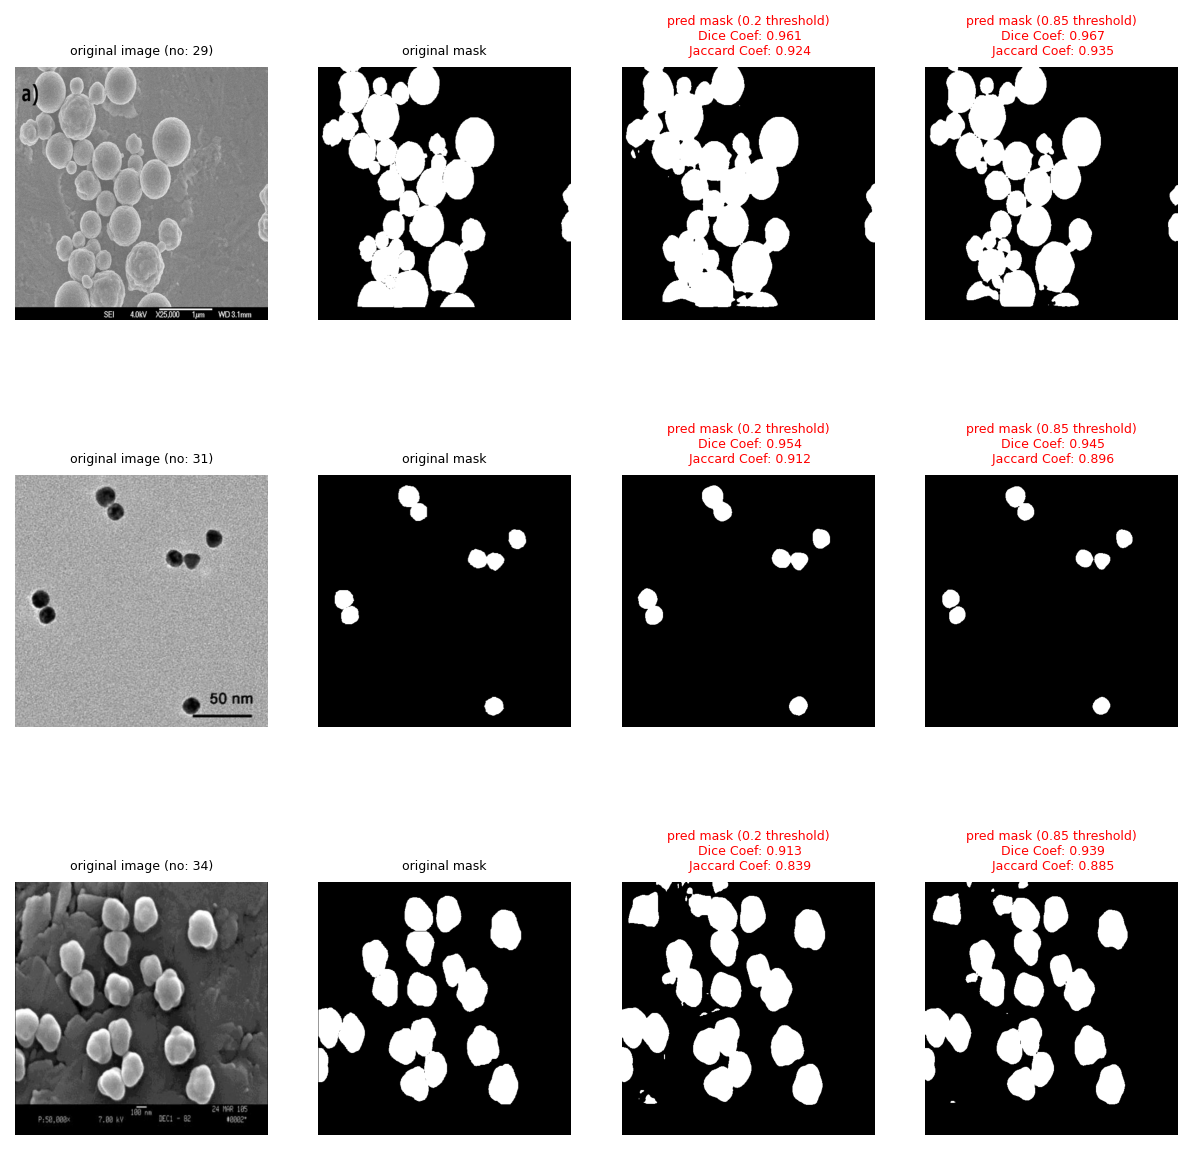

In [18]:
random_test_sample_with_prediction(SEED = 8)
random_test_sample_with_prediction(SEED = 5)